# Contextual Forests V2

### 1. BabelNet Iinterface

In [1]:
import requests
import json
import wikipediaapi
import time
from socket import timeout
from requests.exceptions import ConnectionError

#GLOBAL VARIABLES
wiki = wikipediaapi.Wikipedia('en')
KEY  = 'b361cac5-2b53-40a8-8df8-6a2cfb140491' #Register in BabelNet to get one f2bf42de-488b-4c87-a1c3-1c1878afc263'#'
BASE = 'https://babelnet.io/v5'
API = {
    "get_info": "getSynset",
    "get_synsets":"getSynsetIds",
    "get_relations":"getOutgoingEdges"
}

def __format_arguments(args):
    """
    Desc: Returns a formatted string for making an HTML request
    Params: - args (dict): dictionary for params values, format is {paramName:paramValue ...}
    Returns: (String) formatted string
    """
    return "&".join(["{}={}".format(key,value) for key,value in args.items()])

def __make_request(args,op,verbose=False):
    """
    Desc: Makes arequest to BabelNet API given a parametters dictionary
    Params: - args (dict): dictionary for params values, format is {paramName:paramValue ...}
            - op (string): operation, choose between {get_info,get_synsets,get_relations}
            - verbose (bool): show messages 
    Returns: (Dict) BabelNet's API response
    """
    args["key"] = KEY
    args["targetLang"] = "EN"
    r = requests.get("{}/{}?{}".format(BASE,API[op],__format_arguments(args)))
    if verbose:
        print("Status code: {}".format(r.status_code))
    return r.json() if r.ok else None

def synset_info(synset_id,verbose=False):
    """
    Desc: Returns the information associated with a BabelNet synset
    Params: - synset_id (String): BabelNet synset id
            - verbose (bool): show messages 
    Returns: (Dict) BabelNet's sysnset information
    """
    return __make_request({"id":synset_id},"get_info",verbose)

def synset_relations(synset_id,verbose=False):
    """
    Desc: Returns the outgoing semantic relations of a synset
    Params: - synset_id (String): BabelNet synset id
            - verbose (bool): show messages 
    Returns: (Dict) BabelNet's sysnset outgoing conexions
    """
    try:
        return __make_request({"id":synset_id},"get_relations",verbose)
    except (ConnectionError,timeout):
        return []

def general_categories(synset_id):
    """  
    Desc: Returns the ids of the general categories a synset belongs to
    Params: - synset_id (String): BabelNet synset id
    Returns: (List)[String] ids 
    """
    try:
        categories = [relation["target"] for relation in synset_relations(synset_id) 
                  if relation["pointer"]["shortName"] in ["is-a","part_of","subclass_of"]]
        res = []
        for cat in categories:
            try:
                #res.append(synset_info(cat)["senses"][0]["properties"]["fullLemma"])
                res.append(synset_info(cat)["senses"][0]["properties"]["synsetID"]["id"] )
            except IndexError:
                continue
        return set(res)
    except (ConnectionError,timeout):
        return []

def wiki_page(synset_id):
    """  
    Desc: Return the wikipedia page associated with a synset id
    Params: - synset_id (String): BabelNet synset id
    Returns: (Wikipediaapi.Page) wikipedia page object
    """
    try:
        synset = synset_info(synset_id)
        for sense in synset["senses"]:
            if sense['properties']["source"] == "WIKI":
                return wiki.page(sense['properties']["fullLemma"].replace("_"," "))
            else:
                continue
        return None
    except (ConnectionError,timeout):
        return None

def search_synsets(lemma,pos,searchLang="EN",verbose=False):
    """  
    Desc: Returns the ids of possible synsets associated to the provided word
    Params: - lemma (String): word for searching
            - pos (String): position (NOUN,VERB ...)
            - searchLang (String): language for search and results
            - verbose (bool): show messages 
    Returns: (List)[String]: ids 
    """
    args = {
        "lemma":lemma,
        "pos":pos,
        "searchLang":searchLang,
        "key":KEY
    }
    return [ele["id"] for ele in __make_request(args,"get_synsets",verbose)]


#search_synsets("apple","NOUN")   
#general_categories("bn:17306106n")
#wiki_page("bn:00289737n").text
#synset_info("bn:03094945n")["domains"]
        
    
                   

### Wikipedia Interface

In [2]:
import spacy
import en_core_web_lg
from nltk.stem.porter import *
from more_itertools import locate
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
import string
import numpy as np
from scipy.optimize import curve_fit
from nltk.stem import WordNetLemmatizer 

stemmer = SnowballStemmer(language='english')
lemmatizer = WordNetLemmatizer() 
nlp = en_core_web_lg.load()
STOPWORDS = "stopwords.txt" #stopwords_file
with open(STOPWORDS ) as file:
        stop_words = [x.strip() for x in file.readlines()]

In [3]:

def average_sentence_size(text):
    """Returns the average sentence size"""
    return np.mean([len(sentence.split()) for sentence in text.split(".")])

def clean_text(text):
    """Cleans the text, punctuation marks (. , \n) will be replaced by blank spaces 
    and possessive forms ('es , 's) will be removed. 
    Any other punctuation symbol will also be removed.
    @Params:
        -text: to be cleaned
    @Returns:
        Cleaned text
    """
    text = text.replace("\n"," ").replace(","," ").replace("."," ")
    text = text.replace("'s","").replace("'es","")
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

def stem_text(text,title=""):
    #pendiente hacerlo mas elegante
    """
    Uses snowball stemmer to produce a dictionary with entries:
        dic = { ...,key:(words,occurr,relevance),... }
    Where words -> list of ocurrences of key in text (page's text)
          occur -> indexes of (key) occurrences in the text
          relevance -> set to 0 (see set_relevance())
    Note that every key = (STEMMED WORD,WORD_POS (Part Of Speech))
    @Params:
        - text: text to be processed
    @Returns:
        (stem_dictionary,cleaned text length)
    """
    dic = {}
    content = clean_text(text).split() #split spaces
    count = 0
    for i,x in enumerate(nlp(clean_text(text))):
        if x.pos_ not in ["NOUN","PROPN","VERB","ADJ"]:
            continue
        try:
            int(x)
            continue
        except:
            if x.text.lower() not in stop_words and "wikipedia" not in x.text.lower() and title not in x.text.lower() :
                stemmed = stemmer.stem(x.text.lower())
                key = (stemmed,x.pos_)
                if key not in dic:
                    dic[key] = {"words":set([x.text.lower()]),"occurr":[i],"relevance":.0,"pos":0}
                else:
                    dic[key]["words"].add(x.text.lower())
                    dic[key]["occurr"].append(i)
        count += 1
    return dic,len(content),text




def relevance(word,text_len,chunk_size=100): #AQUI TENEMOS EL CUELLO DE BOTELLA
    """
    Returns word relevance (probability of being in a randomly 
    positioned block of a fixed size).
    @Params:
        - word:  entry of stem_dict
        - text_len: text size (returned by stem_text())
        - chunk_size: block size, fixed
    """
    L = []
    for i in range(chunk_size,text_len,1):
        added = False
        for occ in word["occurr"]:
            if occ > i - chunk_size and occ <= i:
                L.append(1)
                added = True
                break
        if not added:
                L.append(0)
    #print("SUMA",np.sum(L),"LOng",len(L))
    return np.mean(L)    
    
def set_relevance(stem_dict,text_len,text,sort=False):
    relevances = []
    if text_len < 100: #no aceptamos artículos de menos de 300 palabras
        return None
    else:
        t1 = time()
        n_chunks = int(text_len/average_sentence_size(text)) #por ejemplo, mirar otras posibilidades dinamicas etc...
        for word in stem_dict:
            res = relevance(stem_dict[word],text_len,n_chunks)
            stem_dict[word]["relevance"] = res
        t2 = time()
    if sort:
        t3 = time()
        keys = sorted(stem_dict.keys(),key=lambda k:stem_dict[k]["relevance"], reverse=True)
        for i,key in enumerate(keys):
            stem_dict[key]["pos"] = i
        t4 = time()
   # print("1"+"#"*50,t2-t1)
   # print("2"+"#"*50,t4-t3)
    return stem_dict


def fit_model(stem_dict):
    y_data = []
    if stem_dict == None: #articulo demasiado corto
        return None,None
    keys = sorted(stem_dict.keys(),key=lambda k:stem_dict[k]["relevance"], reverse=True)
    for i,key in enumerate(keys):
        stem_dict[key]["pos"] = i
        y_data.append(stem_dict[key]["relevance"])
    y_data = np.array(y_data)[y_data != 0][0] 
    x_data = np.linspace(1,len(y_data),len(y_data))
    def zipf(x,alpha): #distribucion de Zipf
        return stem_dict[keys[0]]["relevance"]/x**alpha

    popt, pcov = curve_fit(zipf,x_data,y_data)
    return lambda x: zipf(x,popt),stem_dict

def link_relevance(link,stem_dict,model):
        words = nlp(link)
        rel = []
        if ":" in link:
            return 0
        for word in words:
            try:
                pos =  stem_dict[(stemmer.stem(word.text.lower()),word.pos_)]["pos"]
                rel.append(pos)
            except KeyError:
                rel.append(len(stem_dict))
        return model(np.mean(rel))[0] if  len(rel) * sum(rel)  != 0  else 0      

def relevant_links(page,top):
    
    stem_dict = set_relevance(*stem_text(page.text,title=page.title))
    model,stem_dict = fit_model(stem_dict)
    if model is None:
        return []
    return sorted(page.links.items(),key=lambda it: link_relevance(it[0],stem_dict,model),reverse=True)[:top]


#relevant_links(wiki.page("Apple Inc."),10)

### From terms to targetted texts

In [4]:
def generalization(synset_id,top,l=[],level=1):
    if level > top:
        return 
    else:
        try:
            for child in general_categories(synset_id):
                l.append((child,level))
                generalization(child,top,l,level+1)
            return l
        except:
            return 
def concretization(page,top,max_expand,l=[],level=1):
    if level > top:
        return 
    else:
        try:
            for _,child in relevant_links(page,max_expand):
                l.append((child,level))
                concretization(child,top,max_expand,l,level+1)
            return l
        except:
            return []
    
class Concept():
    """Contains all the texts associated with a concept,
        each with an associated level of specificity"""
    def __init__(self,synset_id,pos,depth_up,depth_down):
        self.synset_id = synset_id
        self.depth_up,self.depth_down = depth_up,depth_down
        self.page = wiki_page(synset_id)
        self.pages = []
        
        if pos is "NOUN": #standard text mining
            #generalization
            for s_id,level in generalization(synset_id,depth_up):
                synset_page = wiki_page(s_id)
                if synset_page != None and synset_page.exists():
                    self.pages.append((synset_page,level))
            
            #concretization
            max_expand = int(np.ceil(np.power(len(self.pages),1/depth_down)))
            #for page,level in concretization(self.page,depth_down,max_expand):
            #self.pages += [(link[1],-1) for link in relevant_links(self.page,len(self.pages))]
            self.pages = set(self.pages)   
                
#c = Concept( "bn:00005054n ","NOUN",1,1) #apple inc.         

#print(c.pages)

### Article-Article distance

In [821]:
import sys
%matplotlib notebook
from matplotlib import pyplot as plt
page1 = wiki.page("")
m1,d1 = fit_model(set_relevance(*stem_text(page1.text,title=page1.title.lower())))
page2 = wiki.page("")
m2,d2 = fit_model(set_relevance(*stem_text(page2.text,title=page2.title.lower())))
("appl","NOUN") in d2


banana
apple


False

436
('fruit', 'NOUN') 0 0
('cultivar', 'NOUN') 1 2
('includ', 'VERB') 6 3
('produc', 'VERB') 2 13
('grow', 'VERB') 11 6
('plant', 'NOUN') 3 23
10.490034143249039
6 384


<IPython.core.display.Javascript object>


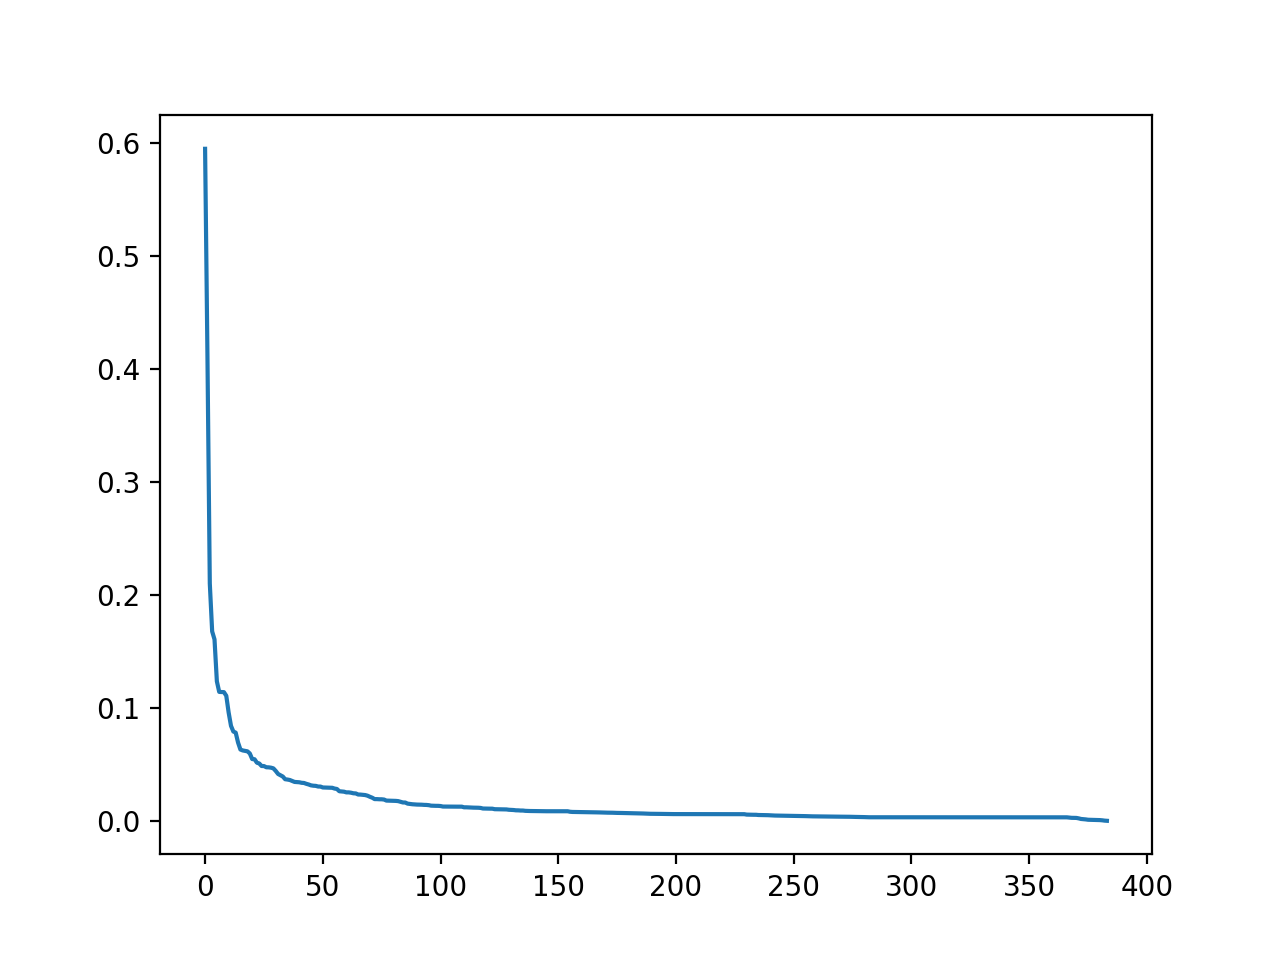

<function matplotlib.pyplot.show(*args, **kw)>

In [822]:
s1 = [key for key in d1 if key in d2]
print(len(s1))
s1 = sorted(s1,key=lambda k: (d1[k]["relevance"]*d2[k]["relevance"])/(1+abs(d1[k]["relevance"]-d2[k]["relevance"]
)),reverse=True)
vals = np.array([(d1[k]["relevance"]*d2[k]["relevance"])/(1+abs(d1[k]["relevance"]-d2[k]["relevance"])) for k in s1])
vals = vals[vals>0]
diff = np.abs(np.diff(vals))
#top = diff / np.array(vals[:-1])
x = np.argmax(diff<0.001*diff[0])
#x=40
X = np.array([d1[x]["pos"] for x in s1[:x+1]]) #/len(d1)
Y = np.array([d2[x]["pos"] for x in s1[:x+1]]) #/len(d2)
#print(max(c1,c2))

for l in s1[:x]:
    print(l,d1[l]["pos"],d2[l]["pos"])
v1 = np.zeros(2) 
v = np.array([np.mean(X),np.mean(Y)])
print(np.linalg.norm(v1-v))
print(x,len(vals))
#plt.scatter(X,Y)
#plt.scatter(np.mean(X),np.mean(Y),color='r')
#plt.show
plt.plot(vals)
plt.show


In [647]:
from time import time
import sys

wiki_freqs = {}
mx = 0
with open("wiki_freqs.txt") as f:
    for line in f.readlines():
        word,freq = line.split(" ")
        if int(freq) > mx:
            mx = int(freq)
        wiki_freqs[word] = int(freq)
    for k in wiki_freqs:
        wiki_freqs[k] = 1+wiki_freqs[k]/mx
def inv_freq(k,d):
    try:
        for key in d:
            if d[key]["pos"] == 0:
                mx = d[key]["relevance"]
        return 1/wiki_freqs[d[k]["words"].pop()] * 2*mx
    except KeyError:
        return 0
def aa_distance(d1,d2):
    if d1 is None or d2 is None:
        return np.inf
    s1 = [(k,(inv_freq(k,d1)*d1[k]["relevance"]*d2[k]["relevance"]*inv_freq(k,d2))/(1+abs(d1[k]["relevance"]*inv_freq(k,d1)-d2[k]["relevance"]*inv_freq(k,d2)))**2) for k in d1 if k in d2]
    if (len(s1) < 0.01*len(d1) and len(s1) < 0.01*len(d2)):
        return np.inf
    s1,vals = zip(*sorted(s1,key=lambda it: it[1],reverse=True))
    diff = np.abs(np.diff(vals))
    if len(diff) == 0:
        return np.inf 
    x = np.argmax(diff<0.01*diff[0])
    X,Y = zip(*[(d1[y]["pos"],d2[y]["pos"]) for y in s1[:x]])
    m = max(len(d1),len(d2))
    print(s1[:x])
    X_,Y_ = np.array(X)*len(d2)/m,np.array(Y)*len(d1)/m
    print(X_,Y_)
    return (np.abs(np.median(X) - np.median(Y)))
    print(len(d1),len(d2))
    #v1,v2 = np.median(np.array(np.array(X)*len(d2)/len(d1)),np.median(np.array(Y))
    return v1*v2/(1+abs(v1-v2))


p1 = wiki.page("Donald Trump")
p2 = wiki.page("Bill Clinton")
d1 = set_relevance(*stem_text(p1.text,title=p1.title.lower()),sort=True)
d2 = set_relevance(*stem_text(p2.text,title=p2.title.lower()),sort=True)
#%time  aa_distance(d1,d2)


In [648]:
%time aa_distance(d1,d2)  

(('unit', 'PROPN'), ('year', 'NOUN'), ('campaign', 'NOUN'), ('white', 'PROPN'), ('state', 'PROPN'), ('presid', 'NOUN'), ('presidenti', 'ADJ'), ('polit', 'ADJ'), ('feder', 'ADJ'), ('american', 'ADJ'), ('polici', 'NOUN'), ('elect', 'NOUN'), ('democrat', 'ADJ'), ('public', 'ADJ'), ('congress', 'PROPN'), ('state', 'NOUN'), ('administr', 'NOUN'), ('republican', 'PROPN'), ('york', 'PROPN'), ('time', 'NOUN'), ('peopl', 'NOUN'))
[ 3.04029991  3.80037488  6.84067479 11.40112465  1.52014995  5.32052484
  6.08059981 14.44142455 12.16119963 17.48172446 15.20149953 15.96157451
 26.60262418 33.44329897 20.52202437 21.28209934  8.36082474 25.8425492
 24.32239925 23.56232427 57.76569822] [ 5.  2.  8. 16.  7.  1. 40. 21. 26. 15. 14. 11. 23. 18. 36. 27. 20. 33.
 62.  6. 44.]
2.0
CPU times: user 1.74 s, sys: 5.12 ms, total: 1.75 s
Wall time: 1.74 s


In [6]:
c1 = Concept( "bn:00005054n ","NOUN",1,1) 



In [13]:
c2 = Concept( "bn:03259764n","NOUN",1,1) 

In [14]:
concept_distance(c1,c2)

(1, 7, 110, 5, 18, 15, 13, 86, 3, 20, 87, 114, 70, 11, 32, 8, 4, 63, 9, 72, 68, 27, 112, 128, 130, 41, 10, 12, 40, 69) (113, 34, 0, 107, 32, 53, 89, 4, 266, 63, 7, 8, 15, 191, 22, 277, 1029, 44, 281, 55, 79, 136, 115, 57, 47, 156, 1078, 675, 163, 175)
(24, 36, 40, 17, 32, 28, 20, 101, 7, 87, 138, 8, 142, 9, 114, 152, 27, 16) (8, 10, 12, 191, 22, 63, 247, 34, 1056, 54, 55, 625, 59, 412, 71, 89, 136, 769)
(3, 25, 104, 4, 1, 29, 53, 12, 21, 11, 87, 101) (32, 12, 0, 191, 1061, 40, 13, 144, 155, 266, 34, 41)
(0, 15, 5, 8, 28, 7, 3, 20, 24, 13, 14, 75, 31, 21, 62, 66, 4, 126, 57, 79) (48, 0, 16, 7, 3, 32, 96, 13, 19, 40, 42, 2, 44, 61, 10, 41, 955, 52, 55, 79)
(24, 19, 25, 1, 18, 33, 20) (48, 96, 191, 1078, 256, 281, 817)
(47, 33, 39, 0, 1, 67, 17, 18, 42, 43) (3, 15, 19, 1083, 430, 32, 40, 42, 54, 71)
(4, 0, 11, 20, 15, 2, 23, 3, 6, 7) (16, 1070, 32, 54, 80, 1083, 266, 1096, 316, 1022)
(4, 7, 3, 9, 46, 25, 12, 8, 107, 19) (0, 53, 242, 191, 3, 80, 181, 275, 19, 166)
(15, 19, 23, 3, 30, 163, 

(22, 7, 24, 9, 75, 83, 88, 132, 36, 87, 138, 144, 8, 60, 34, 118, 29, 128, 114, 101, 85, 158, 35) (1, 109, 58, 278, 6, 16, 42, 46, 66, 78, 79, 83, 696, 112, 215, 297, 558, 303, 310, 340, 360, 63, 442)
(22, 114, 83, 40, 75, 87, 138, 88, 139) (85, 40, 44, 48, 55, 107, 155, 181, 271)
(24, 27, 29, 22, 128, 28, 34) (24, 16, 55, 171, 60, 99, 98)
(22, 114, 83, 40, 75, 87, 138, 88, 139) (85, 40, 44, 48, 55, 107, 155, 181, 271)
(137, 22, 144, 29, 122, 40) (1, 159, 27, 75, 47, 80)
(9, 29, 7, 119, 60, 87, 22, 14, 40, 144, 136, 122, 135, 8, 132, 10, 138, 96, 24, 20, 74) (174, 53, 409, 48, 73, 74, 312, 512, 126, 132, 152, 167, 185, 1063, 236, 1068, 293, 316, 670, 1098, 520)
(24, 75, 22, 152, 32, 132, 36, 8) (20, 1, 59, 7, 22, 30, 66, 844)
(22, 75, 138, 36, 87, 32, 88, 132, 119, 70) (2, 3, 34, 41, 53, 91, 93, 117, 142, 175)
(22, 29, 87, 75, 40, 60, 70, 88, 83, 36, 122, 86, 128, 138, 135) (106, 24, 16, 33, 40, 54, 77, 84, 155, 174, 185, 193, 223, 255, 297)
(83, 40, 22, 128, 75, 144, 9, 87) (55, 72, 3

(6, 20, 11, 54, 2, 21, 63, 23, 10, 7, 118, 70, 105, 76, 24, 68, 518, 60, 232, 59, 395, 143, 64, 413, 402, 162, 121) (21, 9, 73, 24, 259, 99, 34, 101, 297, 307, 35, 71, 37, 87, 228, 118, 6, 168, 14, 202, 40, 153, 320, 55, 57, 149, 227)
(20, 6, 130, 33, 458, 118, 181, 204) (29, 79, 27, 57, 10, 62, 93, 51)
(6, 10, 11, 20, 24, 33, 51, 58, 80, 7, 30, 13, 28, 105, 19, 68, 54, 128, 395, 151, 76, 413, 70, 518, 131, 98, 149, 373, 75, 536, 507, 21, 89, 232, 135, 118) (25, 15, 36, 85, 203, 184, 112, 92, 55, 415, 269, 354, 280, 37, 435, 204, 315, 121, 10, 102, 253, 26, 360, 31, 233, 291, 238, 57, 549, 30, 75, 1356, 558, 98, 385, 424)
(6, 11, 2, 20, 24, 10, 44, 17, 3, 14, 32, 58, 76, 51, 30, 38, 68, 80, 154, 54, 74, 13, 61, 7, 105, 107, 151, 34, 60, 59, 181, 143, 152, 21, 413, 131, 23, 65, 70, 28, 90, 75, 125) (4, 45, 210, 54, 69, 269, 53, 231, 516, 284, 152, 46, 33, 92, 259, 220, 72, 36, 8, 143, 84, 523, 154, 921, 59, 67, 39, 446, 274, 303, 15, 109, 93, 685, 6, 142, 802, 479, 375, 951, 288, 444, 2

(10, 67, 38, 68, 16) (21, 26, 62, 55, 111)
(5, 131, 40, 323, 116) (2, 1, 6, 0, 5)
(10, 85, 46, 68, 131, 72, 14, 31, 5, 6, 38, 106, 29, 120, 25, 323, 30, 16, 63, 240, 155, 117, 87, 160, 121, 201, 146, 66, 76, 231, 127, 23, 26, 196, 505, 257, 273, 334, 1281, 1138, 159, 58, 870, 424) (25, 0, 30, 26, 7, 36, 172, 138, 273, 230, 134, 40, 179, 34, 204, 4, 214, 259, 171, 15, 55, 93, 156, 61, 118, 35, 109, 257, 271, 56, 191, 505, 404, 94, 1, 99, 102, 75, 8, 10, 233, 521, 17, 33)
(3, 5, 10, 19, 16, 14, 0, 23, 38, 68, 15, 25, 30, 11, 132, 24, 46, 85, 47, 54, 72, 67, 2, 21, 29, 40, 93, 87, 297, 106, 120, 117, 152, 69, 131, 140, 84, 155, 115, 102, 63, 49, 153, 61, 296, 88, 170, 186, 167, 128, 273, 98, 146, 7, 223, 334, 242, 159, 293, 168, 37, 27, 371, 342, 323, 184, 247, 53, 116, 111, 28, 182, 157, 22, 114, 160, 34, 4, 183, 220, 298, 42, 109, 181, 262, 252, 176, 169, 209, 505, 129, 249, 205, 225, 142, 335, 276) (8, 3, 4, 12, 26, 43, 125, 22, 9, 6, 95, 72, 77, 124, 0, 113, 62, 16, 90, 73, 45, 56, 34

(13, 0, 200, 155, 95, 457, 137, 148, 172, 574) (22, 99, 13, 14, 107, 11, 71, 106, 43, 24)
(0, 16, 6, 19, 22, 61, 3, 11, 68, 285, 220, 143, 116) (5, 4, 14, 10, 8, 15, 41, 56, 19, 3, 7, 17, 29)
(17, 19, 63, 170, 236, 206, 773) (28, 18, 32, 19, 21, 53, 23)
(0, 9, 81, 316, 327, 349, 451) (29, 11, 10, 6, 20, 45, 37)
(95, 13, 18, 134, 186, 206) (2, 12, 17, 16, 26, 13)
(3, 13, 134, 95, 102, 114, 349, 359, 939) (17, 33, 16, 22, 52, 27, 34, 29, 18)
(0, 3, 11, 61, 18, 108, 766, 167, 320, 356, 419, 442) (9, 15, 39, 59, 85, 16, 8, 51, 37, 17, 44, 47)
(0, 36, 2, 54, 43, 97, 176, 231, 134, 271) (19, 9, 63, 37, 60, 41, 23, 20, 45, 29)
(0, 61, 2, 75, 17, 30, 310, 674, 85, 86, 166, 167, 1103, 1177, 181, 596, 220) (19, 8, 83, 23, 89, 115, 11, 4, 126, 113, 95, 139, 10, 6, 29, 21, 117)
(5, 0, 30, 17, 68, 3, 35, 47, 60, 121, 57, 36, 11, 75, 78, 152, 161, 53, 2, 86, 23, 42, 137, 143, 1059, 505, 220, 356, 403, 33, 41, 300, 50) (0, 9, 3, 15, 1, 36, 26, 19, 20, 4, 35, 42, 60, 37, 52, 28, 23, 96, 176, 67, 121, 

(1, 17, 21, 70, 4, 6, 95, 32, 105, 18, 218) (3, 10, 9, 21, 59, 58, 26, 40, 27, 69, 28)
(17, 24, 53, 26, 2, 14, 1, 18, 21, 143, 96, 107, 100, 191, 118, 5, 44, 19, 22, 8, 734, 4, 23, 15) (2, 3, 4, 8, 11, 12, 33, 24, 25, 7, 16, 13, 17, 6, 14, 55, 35, 50, 54, 84, 1, 115, 104, 146)
(2, 4, 6, 17, 21, 22, 1, 50, 75, 44, 53, 29, 5, 195, 176, 103, 31, 38, 46, 24, 345, 20, 106, 171, 63, 326, 136, 320, 213, 19, 132, 124, 386, 389, 210, 95, 430, 89, 67, 100, 37, 443, 73, 561, 185, 544, 515, 55, 8, 378, 252, 303, 352, 231, 236, 16, 437, 725, 538, 600) (34, 31, 48, 57, 56, 89, 147, 80, 40, 140, 134, 170, 242, 7, 15, 90, 225, 232, 231, 273, 0, 320, 185, 104, 261, 18, 150, 22, 83, 399, 182, 190, 13, 14, 105, 275, 11, 300, 330, 301, 451, 29, 340, 33, 203, 37, 39, 449, 604, 75, 179, 133, 98, 188, 189, 634, 69, 5, 77, 79)
(1, 2, 5, 4, 6, 14, 20, 22, 24, 31, 3, 37, 16, 11, 23, 15, 18, 36, 8) (2, 3, 1, 4, 7, 5, 15, 16, 17, 11, 49, 10, 37, 42, 30, 39, 40, 24, 62)
(246, 4, 406, 11, 536) (1, 12, 4, 86, 7)
(2,

(19, 39, 12, 25, 21, 84, 125) (4, 14, 94, 98, 122, 5, 3)
(19, 125, 84, 4, 32, 108, 69, 70, 104, 73, 138, 251, 197, 254) (10, 3, 9, 165, 69, 35, 150, 91, 72, 95, 148, 68, 129, 166)
(19, 32, 70, 4, 278, 84, 69, 13, 125, 97, 107, 3, 108, 116) (2, 24, 11, 84, 3, 25, 55, 131, 33, 35, 53, 455, 61, 74)
(19, 70, 64, 20, 108, 84, 22, 4, 69, 13, 97, 125, 116, 113, 52, 149, 270, 115) (57, 34, 80, 284, 33, 56, 340, 604, 242, 506, 140, 147, 162, 173, 431, 185, 14, 231)
(4, 7, 69, 70, 32, 19, 6, 125, 139, 39, 64, 109, 45, 84, 120, 21, 97, 108, 67, 41, 79, 145, 149, 111, 132, 22, 448, 14, 77, 140, 135, 523, 278, 131, 155, 85, 271, 116, 57, 128) (62, 64, 1, 3, 40, 115, 266, 2, 6, 161, 88, 19, 206, 54, 37, 391, 48, 52, 224, 367, 128, 83, 87, 101, 123, 515, 8, 814, 263, 171, 185, 15, 17, 217, 178, 296, 27, 278, 488, 376)


0.00011186292698897741

In [ ]:
0.0012551106301106302

# playground

('Italy', 'French language', 'Latin language', 'Old English')
[0.         0.02887658 0.06962025 0.19699367] [0.         0.11574074 0.27777778 0.40972222]
0.2954905063291139


(632, 108)

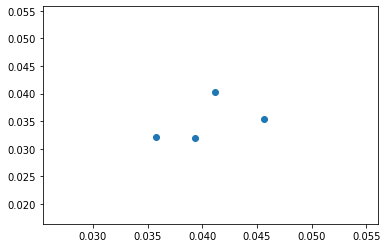

In [326]:
from time import time
from matplotlib import pyplot as plt
def disorder(l1,l2):
    return np.sum([abs(l2.index(l) - i) for i,l in enumerate(l1)])
        

def aa_distance(p1,p2):
    m1,d1 = fit_model(set_relevance(*stem_text(p1.text,title=p1.title.lower()),sort=True))
    m2,d2 = fit_model(set_relevance(*stem_text(p2.text,title=p2.title.lower()),sort=True))
    both = [l for l in p2.links if l in p1.links and ":" not in l and "(" not in l]
    s1 = [(k,(link_relevance(k,d1,m1)*link_relevance(k,d2,m2))/(1+abs(link_relevance(k,d1,m1)-link_relevance(k,d2,m2)))) for k in both]
    #print(len(d1),len(d2))
    #s1 = [(k,(d1[k]["relevance"]*d2[k]["relevance"])/(1+abs(d1[k]["relevance"]-d2[k]["relevance"]))) for k in d1 if k in d2]
    #print(len(d1),len(d2))
    #print(s1)
    #medida de desorden?????
    s1,vals = zip(*sorted(s1,key=lambda it: it[1],reverse=True))
    print(s1)
    muestra = np.array([(link_relevance(k,d1,m1),link_relevance(k,d2,m2)) for k in s1])
    plt.scatter(muestra[:,0],muestra[:,1])
    sorted_links_1 = sorted(p1.links,key=lambda x: link_relevance(x,d1,m1),reverse = True)
    sorted_links_2 = sorted(p2.links,key=lambda x: link_relevance(x,d2,m2), reverse=True)
    vals = np.array(list(vals))
    vals = vals[vals > 0] 
    diffs = np.abs(np.diff(vals))
    if len(diffs) == 0:
        return np.inf 
    x = len(s1)
    X,Y = zip(*[(sorted_links_1.index(y)*s1.index(y)/len(s1),sorted_links_2.index(y)*s1.index(y)/len(s1)) for y in s1[:x+1]]) #/len(d1)
    if len(X) < 3:
        return np.inf
    print(np.array(X)/len(sorted_links_1),np.array(Y)/len(sorted_links_2))
    #v = np.array([(np.sum(X)-n*(n-1))/n,(np.sum(Y)-n*(n-1))/n])
    #print(t3-t2)
    v = np.array(np.sum(np.array(X)/len(sorted_links_1)),np.sum(np.array(Y)/len(sorted_links_2)))
    return np.linalg.norm(v)
    #return np.mean([vals[s1.index(link)]*(X[i]+Y[i]) for i,link in enumerate(s1)])
    #return np.array(vals)/max(vals) @ np.array([min(d1[k]["relevance"],d2[k]["relevance"]) for k in s1])
    #return np.array(vals)/max(vals) @ np.array([min(link_relevance(k,d1,m1),link_relevance(k,d2,m2)) for k in s1])

p1 = wiki.page("Apple")
p2 = wiki.page("Table (furniture)")
print(aa_distance(p1,p2))
len(p1.links),len(p2.links)

In [107]:
def relevance(word,text_len,chunk_size=100): #AQUI TENEMOS EL CUELLO DE BOTELLA
    """
    Returns word relevance (probability of being in a randomly 
    positioned block of a fixed size).
    @Params:
        - word:  entry of stem_dict
        - text_len: text size (returned by stem_text())
        - chunk_size: block size, fixed
    """
    L = 0
    v = np.array(word["occurr"])
    if len(v) < 2:
        return 1/(text_len-chunk_size)
    #occ = v[(v>chunk_size)&(v<text_len-chunk_size)]
    v = v[v<text_len]
    occ = np.diff(v)
    for i,o in enumerate(occ):
        if o > chunk_size:
            if v[i] < chunk_size:
                L += v[i]
            elif text_len - chunk_size < v[i]:
                L += text_len - v[i]
            else:
                L+= chunk_size
        else:
            L += o
    #last one
    if len(v) > 0:
        if v[-1] < chunk_size:
            L += v[-1]
        elif text_len - chunk_size < v[-1]:
            L += text_len - v[-1]
        else:
            L += chunk_size
        #print(L)
        return (L)/(text_len-chunk_size)
    else:
        return 0
    
def relevance2(word,text_len,chunk_size=100): #AQUI TENEMOS EL CUELLO DE BOTELLA
    """
    Returns word relevance (probability of being in a randomly 
    positioned block of a fixed size).
    @Params:
        - word:  entry of stem_dict
        - text_len: text size (returned by stem_text())
        - chunk_size: block size, fixed
    """
    L = []
    for i in range(chunk_size,text_len,1):
        added = False
        for occ in word["occurr"]:
            if occ > i - chunk_size and occ <= i:
                L.append(1)
                added = True
                break
        if not added:
                L.append(0)
    #print("SUMA",np.sum(L),"LOng",len(L))
    return np.mean(L)    
    
    
page1 = wiki.page("Computer")
d,text_len,text = stem_text(page1.text,title=page1.title.lower())
n_chunks = int(text_len/average_sentence_size(text))
d["caca"] = {'occurr':[1,45]}
word = d["caca"]
print(relevance2(word,text_len,n_chunks))
relevance(word,text_len,n_chunks)

0.005267470443638066


0.01041788598852862

In [1342]:
page1 = wiki.page("computer")
t1 = time()
v = stem_text(page1.text,title=page1.title.lower())
t2 = time()
d1 = set_relevance(*v,sort=True)
t3 = time()
print(t2-t1,t3-t2)

1.6718740463256836 0.013387918472290039


In [1344]:
sorted(d1.keys(),key=lambda k: d1[k]["pos"])

[('devic', 'NOUN'),
 ('memori', 'NOUN'),
 ('machin', 'NOUN'),
 ('modern', 'ADJ'),
 ('number', 'NOUN'),
 ('time', 'NOUN'),
 ('data', 'NOUN'),
 ('earli', 'ADJ'),
 ('program', 'NOUN'),
 ('instruct', 'NOUN'),
 ('store', 'VERB'),
 ('call', 'VERB'),
 ('process', 'NOUN'),
 ('thousand', 'NOUN'),
 ('system', 'NOUN'),
 ('perform', 'VERB'),
 ('read', 'VERB'),
 ('develop', 'VERB'),
 ('design', 'VERB'),
 ('design', 'NOUN'),
 ('calcul', 'NOUN'),
 ('built', 'VERB'),
 ('oper', 'NOUN'),
 ('includ', 'VERB'),
 ('special', 'ADJ'),
 ('control', 'NOUN'),
 ('electron', 'ADJ'),
 ('circuit', 'NOUN'),
 ('exampl', 'NOUN'),
 ('digit', 'ADJ'),
 ('unit', 'NOUN'),
 ('allow', 'VERB'),
 ('work', 'VERB'),
 ('arithmet', 'ADJ'),
 ('applic', 'NOUN'),
 ('oper', 'VERB'),
 ('input', 'NOUN'),
 ('cpu', 'NOUN'),
 ('comput', 'NOUN'),
 ('provid', 'VERB'),
 ('type', 'NOUN'),
 ('form', 'NOUN'),
 ('programm', 'ADJ'),
 ('power', 'NOUN'),
 ('function', 'NOUN'),
 ('output', 'NOUN'),
 ('concept', 'NOUN'),
 ('requir', 'VERB'),
 ('complex

<IPython.core.display.Javascript object>


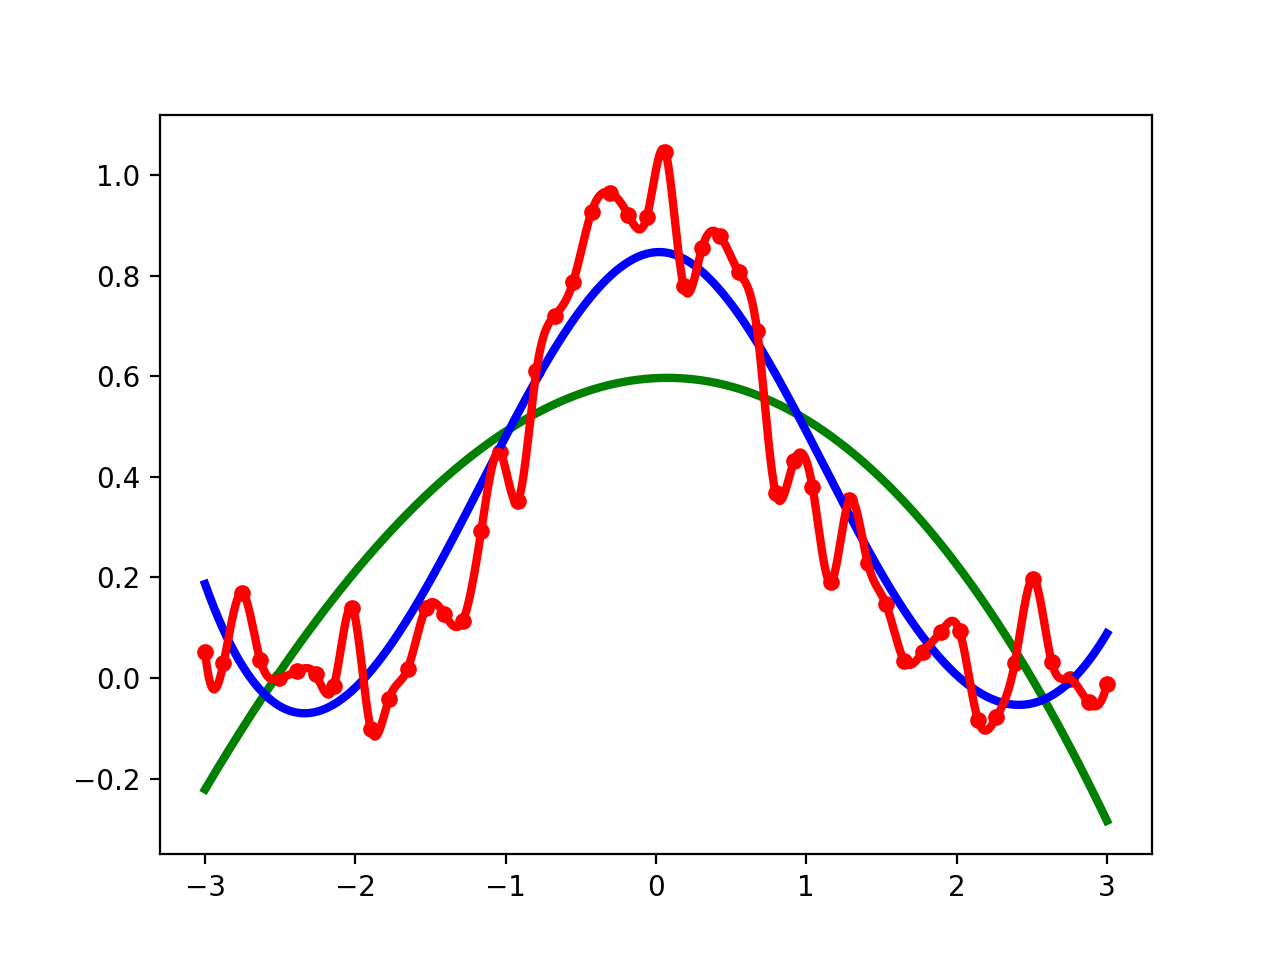

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

x = np.linspace(-3, 3, 50)
y = np.exp(-x**2) + 0.1 * np.random.randn(50)
cs = CubicSpline(x, y)
plt.plot(x, y, 'ro', ms=5)
spl = UnivariateSpline(x, y)
xs = np.linspace(-3, 3, 1000)
plt.plot(xs, spl(xs), 'g', lw=3)
spl.set_smoothing_factor(0.6)
plt.plot(xs, spl(xs), 'b', lw=3)
plt.plot(xs, cs(xs), 'r', lw=3)
plt.show()

In [397]:
A = set([1,2,3])
A.pop()

1

#### 